**Identify different CN types**
- CNs that receive input from bifurcated sensory signal
- CNs that receive input from nonbifurcated sensory signal
    <br>as a result of:
    1. innate and MBON input (CN)
    2. PN and MBON input (innate/CN)
    3. innate and KC input (MBON/CN)

<img src="./diagrams/Bifurcated_CN_types-01.png" alt="" style="width:400px;"/>
<img src="./diagrams/Bifurcated_CN_types-02.png" alt="" style="width:400px;"/>
<img src="./diagrams/Bifurcated_CN_types-03.png" alt="" style="width:400px;"/>


In [2]:
import pymaid
import contools
from contools import Promat, Adjacency_matrix, Celltype_Analyzer, Celltype
import numpy as np
import pandas as pd

from pymaid_creds import url, name, password, token
from data_settings import pairs_path, data_date
rm = pymaid.CatmaidInstance(url, token, name, password)

pairs = Promat.get_pairs(pairs_path)

threshold = 0.01
edge_type = 'ad'
edges_ad = pd.read_csv(f'data/edges_threshold/{edge_type}_pairwise-input-threshold-{threshold}_all-edges_{data_date}.csv', index_col=0)

INFO  : Global CATMAID instance set. Caching is ON. (pymaid)


Path to pairs list is: data/pairs/pairs-2022-02-14.csv


INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)
INFO  : Cached data used. Use `pymaid.clear_cache()` to clear. (pymaid)


In [ ]:
# find all neurons downstream of KC-related PNs
#######
KC_PNs = Celltype_Analyzer.get_skids_from_meta_annotation('mw upstream KCs PN-types')
MBON = pymaid.get_skids_by_annotation('mw MBON')

# neurons to exclude from analysis
pdiff = pymaid.get_skids_by_annotation('mw partially differentiated')
KC = pymaid.get_skids_by_annotation('mw KC')
exclude = list(np.unique(pdiff + KC))

ds_KC_PNs = Promat.downstream_multihop(edges=edges_ad, sources=KC_PNs, hops=1, exclude=exclude, exclude_unpaired=True, pairs=pairs)[0]

ds_MBON = Promat.downstream_multihop(edges=edges_ad, sources=MBON, hops=1, exclude=exclude, exclude_unpaired=True, pairs=pairs)[0]

bifurcated_innate = list(np.setdiff1d(ds_KC_PNs, ds_MBON))

# find all neurons downstream of non-KC PNs (in same modalities)
########
modalities = ['mw olfactory', 'mw gustatory-external', 'mw gustatory-pharyngeal', 
                'mw thermo-cold', 'mw thermo-warm', 'mw visual']

annots = [name + ' 2nd_order PN' for name in modalities]

# identify PNs that don't bifurcate to KC, but in same modalities
PNs = pymaid.get_skids_by_annotation(annots)
innate_PNs = list(np.setdiff1d(PNs, KC_PNs))

ds_innate_PNs = Promat.downstream_multihop(edges=edges_ad, sources=innate_PNs, hops=1, exclude=exclude, exclude_unpaired=True, pairs=pairs)[0]
nonbifurcated_innate = list(np.setdiff1d(ds_innate_PNs, ds_MBON + bifurcated_innate))

In [17]:
# find all neurons downstream of innate and MBON (CN)
bifurcated_LH2N = Promat.downstream_multihop(edges=edges_ad, sources=bifurcated_innate, hops=1, exclude=exclude, exclude_unpaired=True, pairs=pairs)[0]
bifurcated_CN = list(np.intersect1d(bifurcated_LH2N, ds_MBON))

nonbifurcated_LH2N = Promat.downstream_multihop(edges=edges_ad, sources=nonbifurcated_innate, hops=1, exclude=exclude, exclude_unpaired=True, pairs=pairs)[0]
nonbifurcated_CN = np.intersect1d(nonbifurcated_LH2N, ds_MBON)
nonbifurcated_CN = list(np.setdiff1d(nonbifurcated_CN, bifurcated_CN))

# find all neurons downstream of PN and MBON (innate/CN)
bifurcated_innate_CN = list(np.intersect1d(bifurcated_innate, ds_MBON))
nonbifurcated_innate_CN = list(np.intersect1d(nonbifurcated_innate, ds_MBON))

# find all neurons downstream of innate that are MBON (MBON/CN)
bifurcated_MBON_CN = list(np.intersect1d(MBON, bifurcated_LH2N))
nonbifurcated_MBON_CN = np.intersect1d(MBON, nonbifurcated_LH2N)
nonbifurcated_MBON_CN = list(np.setdiff1d(nonbifurcated_MBON_CN, bifurcated_MBON_CN))

/Users/mwinding/anaconda3/envs/larva_learning_env/lib/python3.9/site-packages/contools/celltype.py:304: PerformanceWarning: indexing past lexsort depth may impact performance.
  list(data.loc[index].id)) for index in unique_indices]


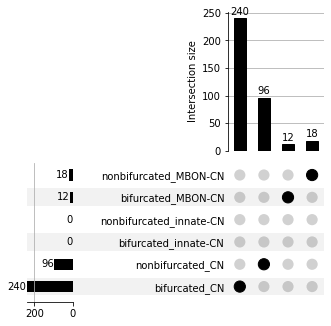

In [19]:
# celltype analysis

names = ['bifurcated_CN', 'nonbifurcated_CN', 'bifurcated_innate-CN', 'nonbifurcated_innate-CN', 'bifurcated_MBON-CN', 'nonbifurcated_MBON-CN']
skids = [bifurcated_CN, nonbifurcated_CN, bifurcated_innate_CN, nonbifurcated_innate_CN, bifurcated_MBON_CN, nonbifurcated_MBON_CN]

CN_types = [Celltype(name=names[i], skids=skids[i]) for i in range(len(names))]

CN_types_cta = Celltype_Analyzer(CN_types)
_ = CN_types_cta.upset_members(plot_upset=True, path='plots/CN-types')